In [52]:
#imports only
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.discriminant_analysis as skl_da
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score

In [53]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)
data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [54]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


In [55]:
data = data.drop(columns=["near_fid"], axis=1) #drop near_fid as it doesnt make sense to have (is only an ID)
semi_original_data = data.copy() #make copy to be able to use later

# Data exploration

In [56]:
# Check correlations between attributes
#from pandas.plotting import scatter_matrix

#attributes = data.columns
#scatter_matrix(data[attributes], figsize=(12,8))

### Distance

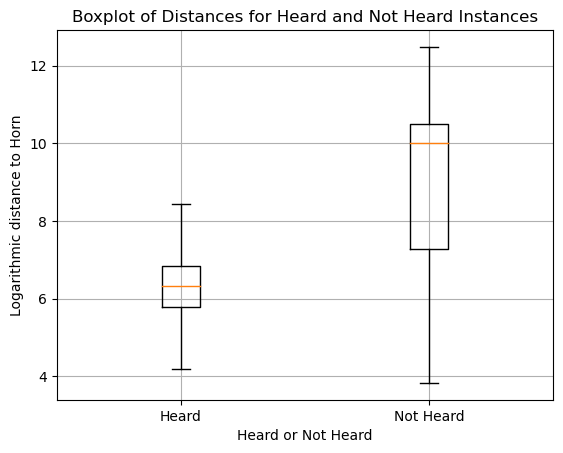

In [57]:
df = data


data['dist_log'] = np.log(data['dist']) #not doing this gives really strange boxplots where the boxes are hard to see
data

log_dist_heard = df[df['heard'] == 1]['dist_log']
log_dist_not_heard = df[df['heard'] == 0]['dist_log']


all_distances = [log_dist_heard, log_dist_not_heard]

plt.boxplot(all_distances, labels=['Heard', 'Not Heard'], showfliers=False)
plt.title('Boxplot of Distances for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Logarithmic distance to Horn')
plt.grid(True)
plt.show()


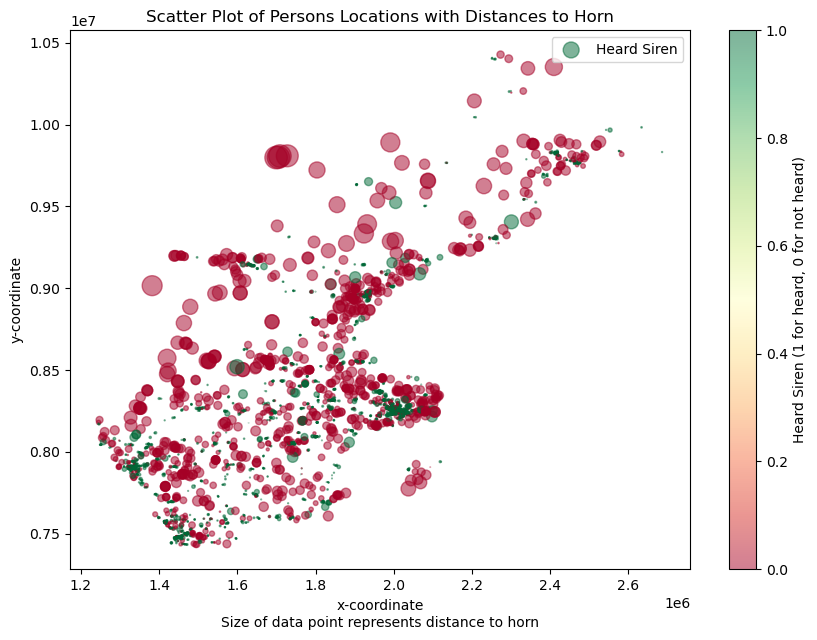

In [58]:
scaling_factor = 0.001  #scaling the distance as some distances are huge

plt.figure(figsize=(10, 7))
scatter = plt.scatter(data["xcoor"], data["ycoor"], alpha=0.5, 
                      c=data["heard"], cmap='RdYlGn', label="Heard Siren",
                      s=data["dist"] * scaling_factor, marker='o')
plt.colorbar(scatter, label='Heard Siren (1 for heard, 0 for not heard)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Scatter Plot of Persons Locations with Distances to Horn')
plt.legend()

plt.text(0.5, -0.1, "Size of data point represents distance to horn", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


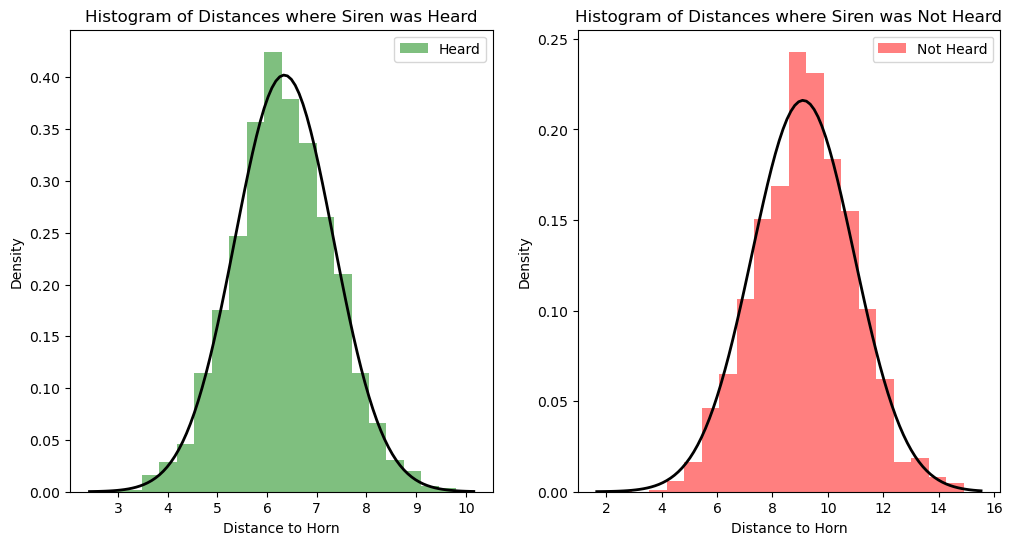

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate synthetic data following a Gaussian distribution for heard and not heard distances
mu_heard = np.mean(log_dist_heard)  # Mean of the distribution for heard distances
sigma_heard = np.std(log_dist_heard)  # Standard deviation of the distribution for heard distances
num_samples_heard = len(log_dist_heard)  # Number of samples for heard distances

mu_not_heard = np.mean(log_dist_not_heard)  # Mean of the distribution for not heard distances
sigma_not_heard = np.std(log_dist_not_heard)  # Standard deviation of the distribution for not heard distances
num_samples_not_heard = len(log_dist_not_heard)  # Number of samples for not heard distances

# Generate synthetic data for heard distances
distances_heard = np.random.normal(mu_heard, sigma_heard, num_samples_heard)

# Generate synthetic data for not heard distances
distances_not_heard = np.random.normal(mu_not_heard, sigma_not_heard, num_samples_not_heard)

# Plot the histograms for heard and not heard distances
plt.figure(figsize=(12, 6))

# Plot for heard distances
plt.subplot(1, 2, 1)
plt.hist(distances_heard, bins=20, density=True, alpha=0.5, color='green', label='Heard')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_heard, sigma_heard)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Horn')
plt.ylabel('Density')
plt.title('Histogram of Distances where Siren was Heard')
plt.legend()

# Plot for not heard distances
plt.subplot(1, 2, 2)
plt.hist(distances_not_heard, bins=20, density=True, alpha=0.5, color='red', label='Not Heard')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_not_heard, sigma_not_heard)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Horn')
plt.ylabel('Density')
plt.title('Histogram of Distances where Siren was Not Heard')
plt.legend()

plt.show()


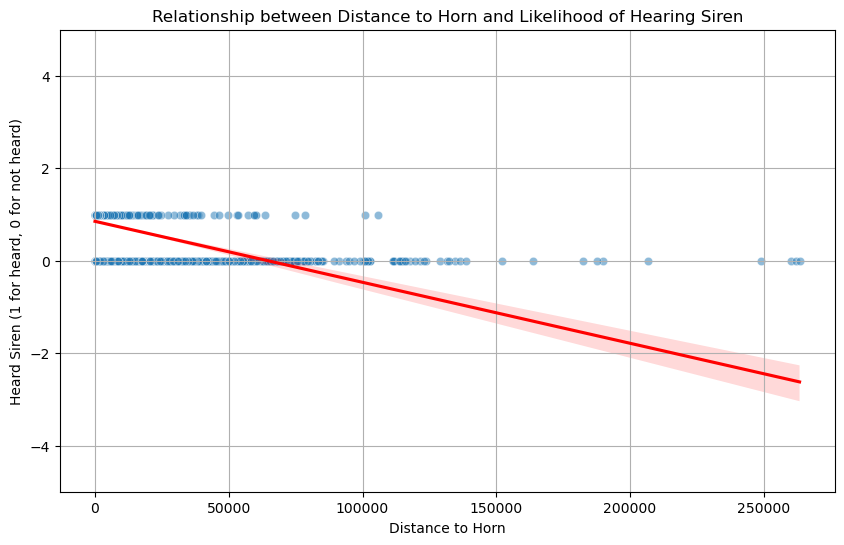

In [60]:
# Assuming 'dist' represents distance and 'heard' represents whether the siren was heard (1 for heard, 0 for not heard)

# Plotting the relationship between distance and likelihood of hearing the siren
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dist', y='heard', data=data, alpha=0.5)

# Fitting a trend line (e.g., linear regression) to visualize the relationship
sns.regplot(x='dist', y='heard', data=data, scatter=False, color='red')

plt.xlabel('Distance to Horn')
plt.ylabel('Heard Siren (1 for heard, 0 for not heard)')
plt.title('Relationship between Distance to Horn and Likelihood of Hearing Siren')

# Set y-axis limits from -3 to 3
plt.ylim(-5, 5)

plt.grid(True)
plt.show()


In [61]:
#### Is there a statistical difference between those that heard the signal and those that didn't given the distance?

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['dist']
not_heard_distances = data[data['heard'] == 0]['dist']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean distances between the heard and not heard groups.")


T-statistic: -51.7056653375075
P-value: 0.0
Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.


## Age

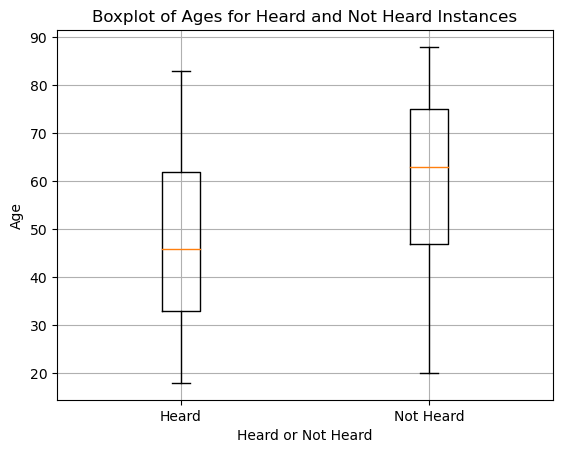

In [62]:
df = data

age_heard = df[df['heard'] == 1]['age']
age_not_heard = df[df['heard'] == 0]['age']

all_ages = [age_heard, age_not_heard]

plt.boxplot(all_ages, labels=['Heard', 'Not Heard'])
plt.title('Boxplot of Ages for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Age')
plt.grid(True)
plt.show()


In [63]:
# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['age']
not_heard_distances = data[data['heard'] == 0]['age']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean ages between the heard and not heard groups.")


T-statistic: -22.79964593973161
P-value: 3.3998771811922806e-110
Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.


### Angles

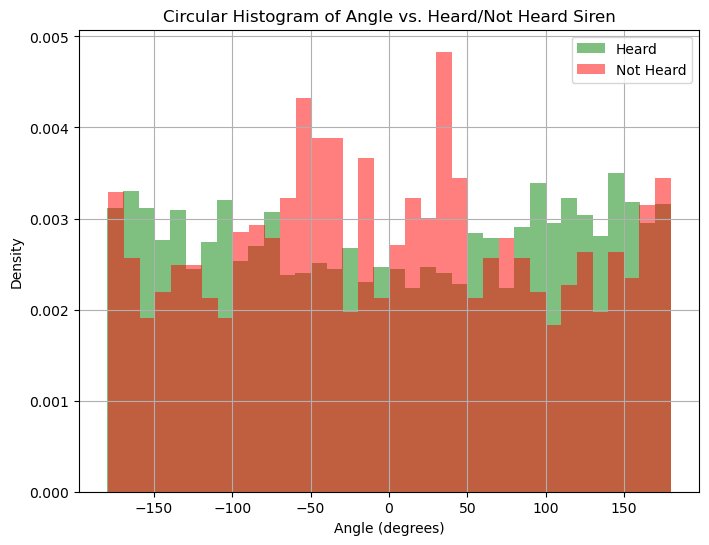

In [64]:
# Extracting data for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Creating a circular histogram for the angles
plt.figure(figsize=(8, 6))

# Plotting histogram for instances where siren was heard
plt.hist(angles_heard, bins=36, density=True, alpha=0.5, color='green', label='Heard')

# Plotting histogram for instances where siren was not heard
plt.hist(angles_not_heard, bins=36, density=True, alpha=0.5, color='red', label='Not Heard')

plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')
plt.xlabel('Angle (degrees)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Setting polar coordinates
#plt.gca().set_theta_zero_location('N')
#plt.gca().set_theta_direction(-1)

plt.show()


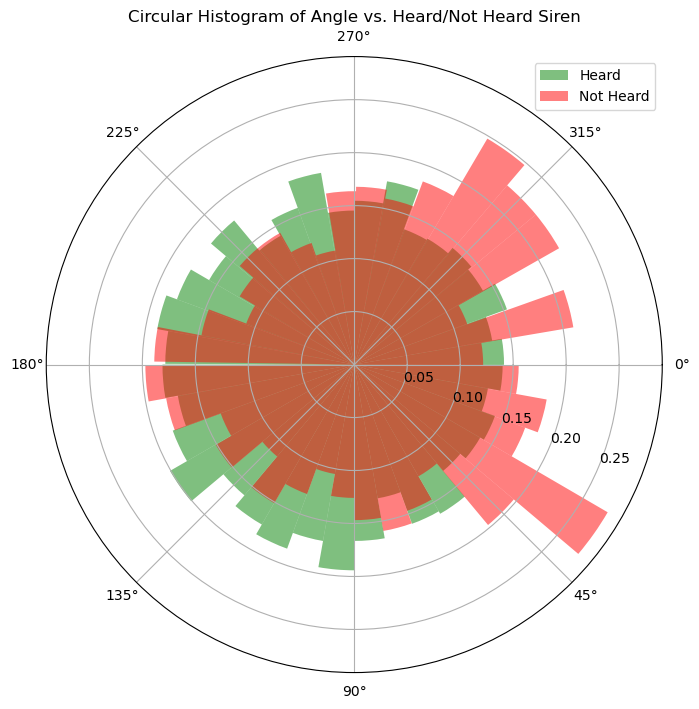

In [65]:
# Assuming 'near_angle' represents the angle data and 'heard' represents whether the siren was heard (1 for heard, 0 for not heard)

# Separate angles for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot angles where the siren was heard
ax.hist(np.radians(angles_heard), bins=36, density=True, alpha=0.5, color='green', label='Heard')

# Plot angles where the siren was not heard
ax.hist(np.radians(angles_not_heard), bins=36, density=True, alpha=0.5, color='red', label='Not Heard')

# Set the direction of the polar plot as clockwise
ax.set_theta_direction(-1)

# Add a legend
plt.legend()
plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')

plt.show()


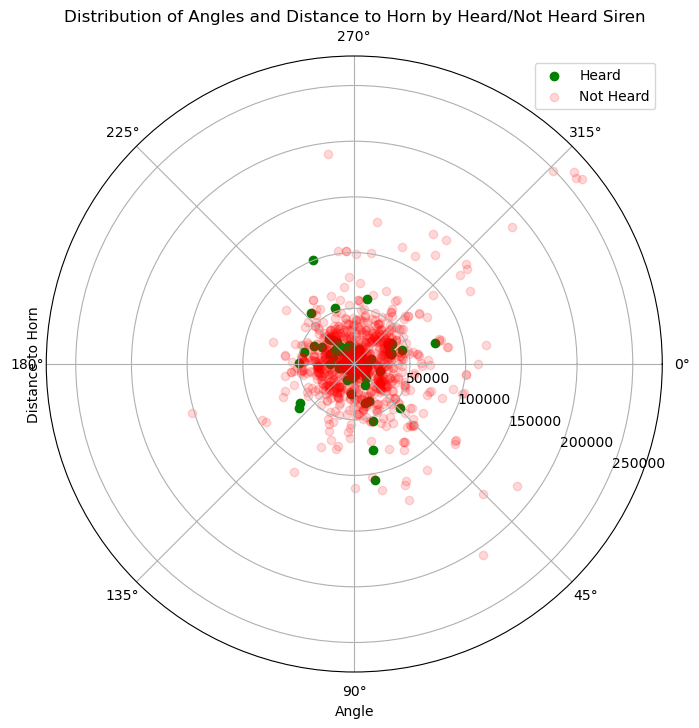

In [66]:
# Assuming 'near_angle' represents the angle data, 'heard' represents whether the siren was heard (1 for heard, 0 for not heard),
# and 'dist' represents the distance to the horn

# Separate angles and distances for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

distances_heard = data[data['heard'] == 1]['dist']
distances_not_heard = data[data['heard'] == 0]['dist']

# Create a polar plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Plot angles where the siren was heard
ax.scatter(np.radians(angles_heard), distances_heard, alpha=1, color='green', label='Heard')

# Plot angles where the siren was not heard
ax.scatter(np.radians(angles_not_heard), distances_not_heard, alpha=0.15, color='red', label='Not Heard')

# Set the direction of the polar plot as clockwise
ax.set_theta_direction(-1)

# Add labels and title
plt.xlabel('Angle')
plt.ylabel('Distance to Horn')
plt.title('Distribution of Angles and Distance to Horn by Heard/Not Heard Siren')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [67]:
#import numpy as np
#from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['near_angle']
not_heard_distances = data[data['heard'] == 0]['near_angle']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean angles between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.")


T-statistic: 0.512822563157527
P-value: 0.6080952897476064
Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.


### Check correlations



In [69]:
data_copy = data.copy()
#data_copy_dum = pd.get_dummies(data, columns=["heard", "building", "noise", "in_vehicle", "asleep", "no_windows"])
data_copy

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,269.161517,5.595312
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,1076.700725,6.981657
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,549.581267,6.309157
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,353.136892,5.866856


In [71]:
#data_copy_dum_wo_categorical.columns

In [76]:
data_copy

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,269.161517,5.595312
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,1076.700725,6.981657
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,549.581267,6.309157
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,353.136892,5.866856


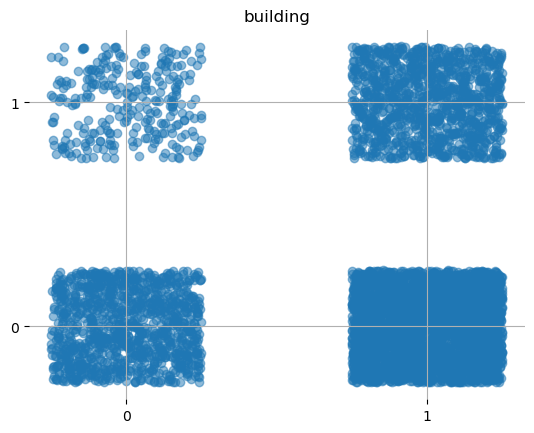

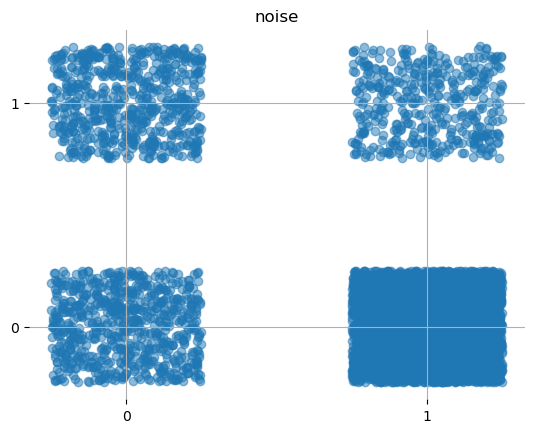

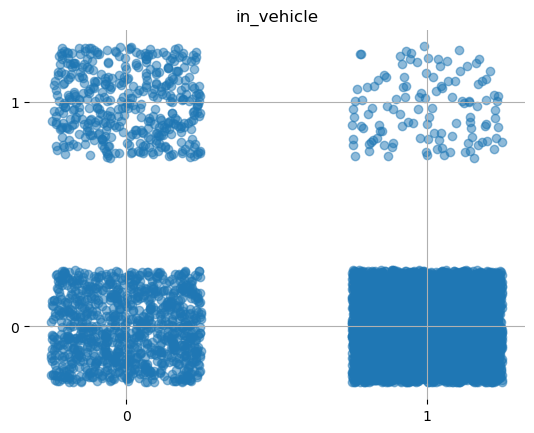

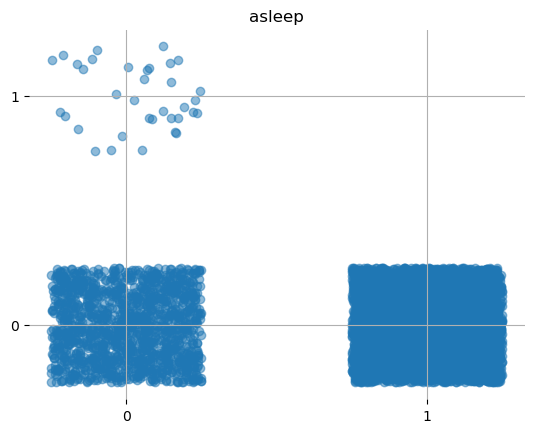

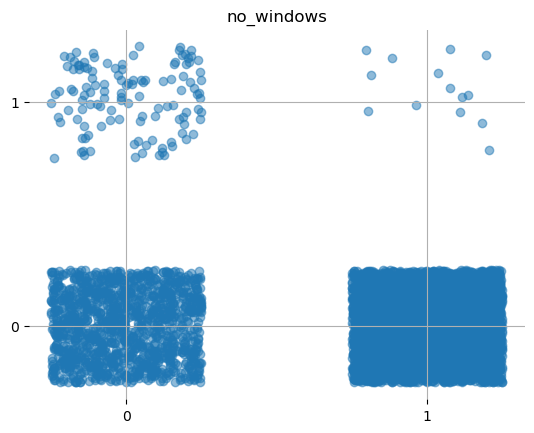

In [89]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def check_two_categorical_variables(target_variable_string, comparison_variable_string):
    # This is to encode the data into numbers that can be used in our scatterplot
    from sklearn.preprocessing import OrdinalEncoder
    ord_enc = OrdinalEncoder()
    enc_data = ord_enc.fit_transform(data_copy)
    enc_df = pd.DataFrame(enc_data, columns=data_copy.columns)
    # Get the categories from the ordinal encoder
    categories = ord_enc.categories_
    
    
    # Generate the random noise
    xnoise, ynoise = np.random.random(len(data_copy))/2, np.random.random(len(data_copy))/2 # The noise is in the range 0 to 0.5
    
    # Plot the scatterplot
    plt.figure()
    plt.scatter(enc_df[target_variable_string]+xnoise, enc_df[comparison_variable_string]+ynoise, alpha=0.5)
    target_index = data_copy.columns.get_loc(target_variable_string)
    comparison_index = data_copy.columns.get_loc(comparison_variable_string)
    
    plt.xticks([0.25, 1.25], categories[target_index]) # Adjust as per your category values
    plt.yticks([0.25, 1.25], categories[comparison_index]) # Adjust as per your category values
    plt.title(comparison_variable_string)
    
    plt.grid()
    sns.despine(left=True, bottom=True)

comparison_array = ["building", "noise", "in_vehicle", "asleep", "no_windows"]

for feature in comparison_array:
    check_two_categorical_variables("heard", feature)

#This result gives reason that we can combine these categorical variables into at least one variable, but possible two


In [90]:
#data["combined"] = data["building"] + data["noise"], data["in_vehicle"], data["asleep"], data["no_windows"]

In [97]:

def combine_attributes(row):
    # one hot encoding
    if row['building'] == 1 and row['noise'] == 1 and row['in_vehicle'] == 1 and row['asleep'] == 1 and row['no_windows'] == 1:
        return 5
    elif row['building'] == 1 and row['noise'] == 1 and row['in_vehicle'] == 1 and row['asleep'] == 1:
        return 4
    elif row['building'] == 1 and row['noise'] == 1 and row['in_vehicle'] == 1:
        return 3
    elif row['building'] == 1 and row['noise'] == 1:
        return 2
    elif row['building'] == 1:
        return 1
    else:
        return 0

# Apply the function to create the combined attribute
data['combined'] = data.apply(combine_attributes, axis=1)

In [98]:
data

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log,combined
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820,0
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362,0
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180,0
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201,0
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,269.161517,5.595312,0
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,1076.700725,6.981657,0
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,549.581267,6.309157,0
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,353.136892,5.866856,0


In [105]:
#subset_data = data[data['combined'] >= 1]
#subset_data

array([[<AxesSubplot:xlabel='combined', ylabel='combined'>]], dtype=object)

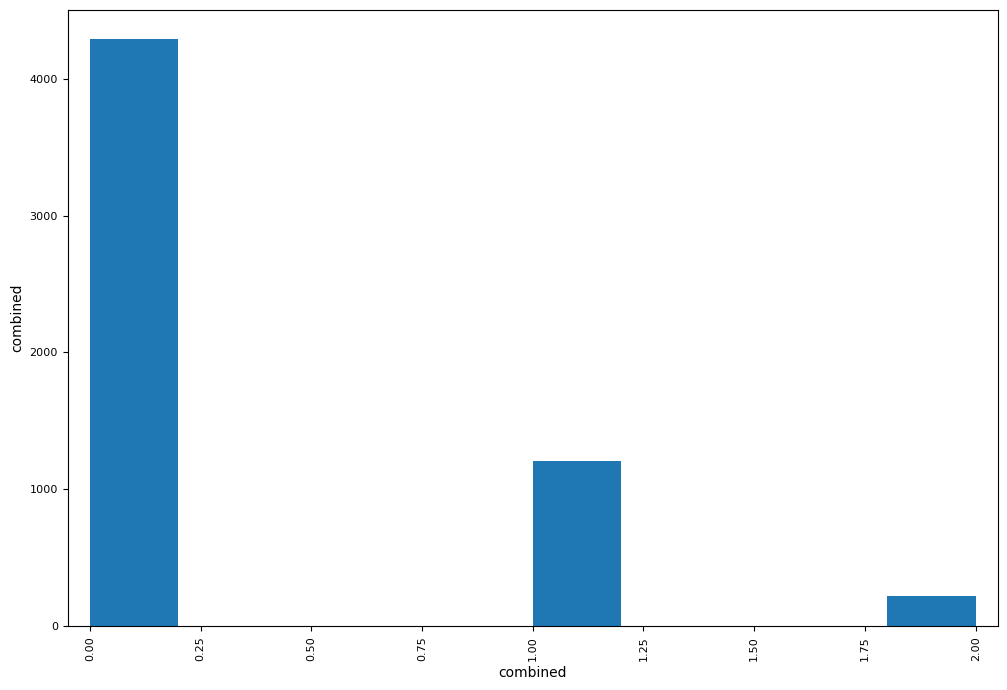

In [110]:
from pandas.plotting import scatter_matrix

attributes = ["heard", "combined"]

scatter_matrix(data[attributes], figsize=(12,8))

# Creating age grouping

In [ ]:
#new bins based on hearing with age research
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']
data['age_group'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)


In [ ]:
dummies = pd.get_dummies(data, columns=["age_group"])
keep_these_original_columns_for_plots = data[["age_group"]]
data = pd.concat([keep_these_original_columns_for_plots, dummies], axis=1)

In [ ]:
data.head(10)

### Explore correlations in the data

# Generate train & test set

In [ ]:
#random sampling
def split_train_test(data, test_ratio, random_state): 
    shuffled_indices = np.random.permutation(len(data)) if random_state is None else np.random.RandomState(random_state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train, test = split_train_test(data, 0.2, random_state=42)

#drop categorical values 
train = train.drop(columns=["age_group"], axis=1)
test = test.drop(columns=["age_group"], axis=1)

X_train = train.drop(columns=['heard'])
y_train = train['heard']

# Extract features and target for testing set
X_test = test.drop(columns=['heard'])
y_test = test['heard']

In [ ]:
X_train

In [ ]:
y_test

# Models

In [ ]:
columns_to_remove = []
X_train_LDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_LDA = X_test.drop(columns=columns_to_remove , axis=1)

In [ ]:
# LDA with SMOTE, standardscaler and gridsearch, this cell is only used to find best params and solver
    
smote = SMOTE()
    
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_LDA, y_train)
    
pipeline = make_pipeline(StandardScaler(), skl_da.LinearDiscriminantAnalysis())
    
# Define hyperparams
param_grid = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
}
    
# grid search with cross-validation
grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search_lda.fit(X_train_resampled, y_train_resampled)
    
# best hyperparams
print("Best hyperparameters:", grid_search_lda.best_params_)
print("Best CV accuracy:", grid_search_lda.best_score_)
    
# use best model going forward
best_lda_model = grid_search_lda.best_estimator_
    
# predict with best model
prediction_lda = best_lda_model.predict(X_test_LDA)
    
#Results
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")
print(f"Accuracy: {np.mean(prediction_lda == y_test):.4f}")

print(classification_report(y_test, prediction_lda))



In [ ]:
# Random forest
model_tree = RandomForestClassifier(n_estimators=440, random_state=42) #defining which modell to be used
model_tree.fit(X_train, y_train)
model_tree_prediction = model_tree.predict(X_test)

print(pd.crosstab(model_tree_prediction, y_test))
print(f"acc: {np.mean(model_tree_prediction == y_test)}")

f1 = f1_score(y_test, model_tree_prediction)
balanced_acc = balanced_accuracy_score(y_test, model_tree_prediction)

# Compute precision and recall
precision = precision_score(y_test, model_tree_prediction)
recall = recall_score(y_test, model_tree_prediction)

print("F1-score:", f1)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_test, model_tree_prediction, digits=4))



In [ ]:
# Boosting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

# rescaling with standardscaler
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

# Bagging classifier
bag = BaggingClassifier(random_state=42, n_estimators=20)
bag.fit(X_train_rescaled, y_train)
prediction = bag.predict(X_test_rescaled)

accuracy = bag.score(X_test_rescaled, y_test)

print("--- Bagging ---")
print(classification_report(y_test, prediction, digits=4))

In [ ]:
# Boosting with AdaBoost

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# rescaling with standardscaler
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

#ada_boost = AdaBoostClassifier(random_state=42, n_estimators=100)
#ada_boost.fit(X_train_rescaled, Y_train)
#Y_predict = ada_boost.predict(X_test_rescaled)

#find best params with GridSearch


# Define the pipeline with preprocessing steps (e.g., scaling) and the AdaBoostClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: preprocessing step
    ('adaboost', AdaBoostClassifier(random_state=42))  # AdaBoostClassifier
])

# Define the hyperparameter grid
param_grid = {
    'adaboost__learning_rate': [1, 2, 5, 10, 25]  # Learning rate hyperparameter for AdaBoostClassifier
}

# Perform Grid Search cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rescaled, y_train)

# Print the best estimator and its hyperparameters
print("Best Estimator: ", grid_search.best_estimator_)

best_estimator = grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the pipeline with preprocessing steps (e.g., scaling) and the AdaBoostClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: preprocessing step
    ('adaboost', AdaBoostClassifier(random_state=42))  # AdaBoostClassifier
])

# Define the hyperparameter grid including both n_estimators and learning_rate
param_grid = {
    'adaboost__n_estimators': [50, 100, 200],  # Number of estimators for AdaBoostClassifier
    'adaboost__learning_rate': [0.01, 0.1, 1.0, 2, 5, 10, 2]  # Learning rate for AdaBoostClassifier
}

# Perform Grid Search cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rescaled, y_train)

# Print the best estimator and its hyperparameters
print("Best Estimator: ", grid_search.best_estimator_)


In [ ]:
# Best Adaboost classifier
best_boost = AdaBoostClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
best_boost.fit(X_train_rescaled, y_train)
prediction = best_boost.predict(X_test_rescaled)

accuracy = best_boost.score(X_test_rescaled, y_test)

pred_accuracy_score = accuracy_score(y_test, prediction)
report = classification_report(y_test, prediction)

print("--- Best AdaBoost ---")
print(classification_report(y_test, prediction, digits=4))

##  Each model as a method to call

In [ ]:
def perform_LDA():
    # LDA with SMOTE, standardscaler and gridsearch
    smote = SMOTE()
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_LDA, y_train)
    
    pipeline = make_pipeline(StandardScaler(), skl_da.LinearDiscriminantAnalysis())
    
    # Define hyperparams
    param_grid = {
        'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
    }
    
    # grid search with cross-validation
    grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
    grid_search_lda.fit(X_train_resampled, y_train_resampled)
    
    # use best model going forward
    best_lda_model = grid_search_lda.best_estimator_
    
    # predict with best model
    prediction_lda = best_lda_model.predict(X_test_LDA)
    
    #Results
    #result = grid_search_lda.best_score_

    result_dict = {}
    result_dict['accuracy'] = np.mean(prediction_lda == y_test)
    result_dict['f1'] = f1_score(y_test, prediction_lda)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, prediction_lda)
    result_dict['precision'] = precision_score(y_test, prediction_lda)
    result_dict['recall'] = recall_score(y_test, prediction_lda)
    
    return result_dict

In [ ]:
def perform_random_forest():
    model_tree = RandomForestClassifier(n_estimators=440, random_state=42) #defining which modell to be used
    model_tree.fit(X_train, y_train)
    model_tree_prediction = model_tree.predict(X_test)
    
    #Results
    result_dict = {}
    result_dict['accuracy'] = np.mean(model_tree_prediction == y_test)
    result_dict['f1'] = f1_score(y_test, model_tree_prediction)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, model_tree_prediction)
    result_dict['precision'] = precision_score(y_test, model_tree_prediction)
    result_dict['recall'] = recall_score(y_test, model_tree_prediction)
    
    return result_dict

In [ ]:
#Script to run all models to get balanced accuracies
num_runs = 10
lda_accuracy_array = []
rf_accuracy_array = []

for i in range(10):
    result_dict_lda = perform_LDA()
    lda_accuracy_array.append(result_dict_lda['accuracy'])
    
    #lda_accuracy_array.append(perform_LDA())
    result_dict_rf = perform_random_forest()
    rf_accuracy_array.append(result_dict_rf['accuracy'])

print("---- LDA ----") #Blended Accuracy: 0.8852
print(f"Blended Accuracy: {np.mean(lda_accuracy_array):.4f}")

print("---- Random Forest ----") #Blended Accuracy: 0.9282
print(f"Blended Accuracy: {np.mean(rf_accuracy_array):.4f}")
